___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___
# Recommender Systems with Python

Welcome to the code notebook for Recommender Systems with Python. In this lecture we will develop basic recommendation systems using Python and pandas. There is another notebook: *Advanced Recommender Systems with Python*. That notebook goes into more detail with the same data set.

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

There is no project for this topic, instead you have the option to work through the advanced lecture version of this notebook (totally optional!).

Let's get started!

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the Data

In [3]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [6]:
df.head()
#this is known as the MovieLens dataset - user_id is the user, item_id is the movie, timestamp is when they gave the review

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Now let's get the movie titles:

In [11]:
#adding in the movie titles
movie_titles = pd.read_csv('Movie_Id_Titles')

In [12]:
movie_titles.head() #notice that we have item_id here

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [14]:
#join movie titles on item_id
df = pd.merge(df, movie_titles, on = 'item_id')

We can merge them together:

In [15]:
df.head() #now we have our movie titles

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

Let's create a ratings dataframe with average rating and number of ratings:

In [22]:
df.groupby(by='title')['rating'].mean().sort_values(ascending=False)
#observations: here we have a descending list of movies with the highest average rating

title
Marlene Dietrich: Shadow and Light (1996)       5.0
Prefontaine (1997)                              5.0
Santa with Muscles (1996)                       5.0
Star Kid (1997)                                 5.0
Someone Else's America (1995)                   5.0
                                               ... 
Touki Bouki (Journey of the Hyena) (1973)       1.0
JLG/JLG - autoportrait de décembre (1994)       1.0
Daens (1992)                                    1.0
Butterfly Kiss (1995)                           1.0
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
Name: rating, Length: 1664, dtype: float64

In [23]:
df.groupby(by='title')['rating'].count().sort_values(ascending=False)
#observations: same list as above but for count (# of ratings)

title
Star Wars (1977)                              584
Contact (1997)                                509
Fargo (1996)                                  508
Return of the Jedi (1983)                     507
Liar Liar (1997)                              485
                                             ... 
Man from Down Under, The (1943)                 1
Marlene Dietrich: Shadow and Light (1996)       1
Mat' i syn (1997)                               1
Mille bolle blu (1993)                          1
Á köldum klaka (Cold Fever) (1994)              1
Name: rating, Length: 1664, dtype: int64

In [25]:
#creates a dataframe that's grouped by title and shows our mean rating
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

In [27]:
ratings

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390
...,...
Young Guns II (1990),2.772727
"Young Poisoner's Handbook, The (1995)",3.341463
Zeus and Roxanne (1997),2.166667


Now set the number of ratings column:

In [29]:
#now we want to add our rating count to our created df
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [30]:
ratings.head()
#here we are!

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now a few histograms:

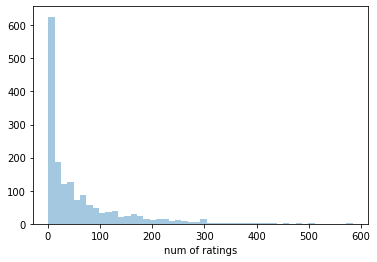

In [32]:
#plot histogram of num of ratings
sns.distplot(ratings['num of ratings'], kde=False)
#most of our num of ratings are quite few (0-10ish range)

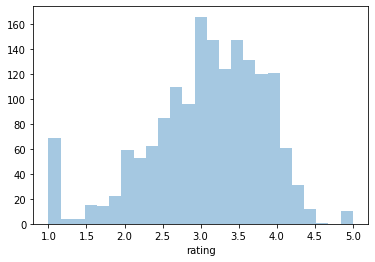

In [33]:
#plot histogram of rating
sns.distplot(ratings['rating'],kde=False)
#observations: quite a few straight 1's, average around 3-4

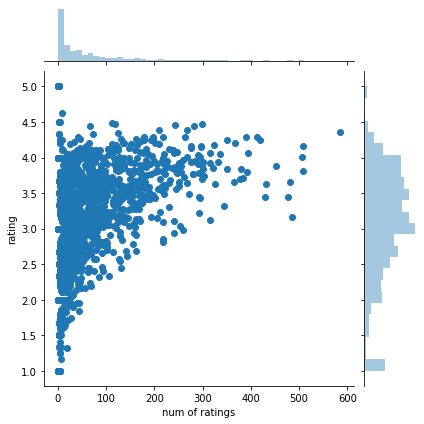

In [36]:
#plot relationship between average ratings and number of ratings
sns.jointplot(x='num of ratings',y='rating',data=ratings)
#observations: looks like there's a trend as num of ratings increases, so too does the rating itself
#(kind of makes sense as typically the better movies have more hype --> more views)

Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

## Recommending Similar Movies

Now let's create a matrix that has the user ids on one axis and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [38]:
#create a matrix using pivot_table function for userid by movie rating (will be many NA's)
moviemat = df.pivot_table(values='rating',index='user_id',columns='title')

In [39]:
moviemat.head()
#we now have our matrix (e.g., user_id = 1 reviewed both 101 Dalmations and 12 Angry Men)

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most rated movie:

In [42]:
ratings.sort_values(by='num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

Now let's grab the user ratings for those two movies:

In [46]:
#pull starwars ratings
starwars_user_ratings = moviemat['Star Wars (1977)']

In [54]:
#preview
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

In [50]:
#pull liar liar ratings
liarliar_user_ratings = moviemat['Liar Liar (1997)']

In [52]:
#preview
liarliar_user_ratings.head()

user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [57]:
#very similar to regular corr.; corrwith will compute the pairwise correlation
#between two df objects (instead of just index and columns of a df)
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
#correlation between user ratings for every other movie and starwars
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

In [58]:
#preview
similar_to_starwars.head()

title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [63]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)

In [64]:
corr_starwars.head()
#this correlation column tells us how similar these movie's ratings were to star wars

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

In [65]:
corr_starwars.sort_values('Correlation',ascending=False)
#observations: some don't really make sense (perfect) yet they are not very similar
#to StarWars (e.g., Commandments?) - likely due to these movies only having
#one review and its user just so happened to also rate Star Wars (very well known)

#to come up with a more appropriate list of related movies, we can filter out movies that had few reviews

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
...,...
For Ever Mozart (1996),-1.0
Frankie Starlight (1995),-1.0
I Like It Like That (1994),-1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [68]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])

ValueError: columns overlap but no suffix specified: Index(['num of ratings'], dtype='object')

In [72]:
corr_starwars = corr_starwars[corr_starwars['num of ratings']>100]

In [74]:
corr_starwars.sort_values('Correlation', ascending=False)
#observations: Star Wars obviously comes back as perfect correlation
#we notice that the other Star Wars sequals are up top, Indiana Jones (similar genre), etc.

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
...,...,...
"Edge, The (1997)",-0.127167,113
As Good As It Gets (1997),-0.130466,112
Crash (1996),-0.148507,128


Now sort the values and notice how the titles make a lot more sense:

Now the same for the comedy Liar Liar:

In [84]:
#create dataframe from the matrix
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])

In [85]:
#get rid of NA's
corr_liarliar.dropna(inplace=True)

In [86]:
#add on number of ratings
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])

In [88]:
#filter for num ratings > 100 (relevancy)
cor_liarliar = corr_liarliar[corr_liarliar['num of ratings']>100]

In [90]:
cor_liarliar.sort_values('Correlation',ascending=False)
#observations: Batman Forever is interesting, The Mask and Down Periscope 
#make sense as they are other comedies

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
...,...,...
Hoop Dreams (1994),-0.184503,117
Ed Wood (1994),-0.199481,133
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),-0.238092,194


# Great Job!